In [1]:
#imports 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

In [2]:
#read in data set up data frame 
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values
df.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [6]:
# couple diffrent reggessions 
reg = np.polyfit(df['Dates'],df['Prices'],deg = 1)
reg2 = np.polyfit(df['Dates'],df['Prices'],deg = 8)
reg3 = np.polyfit(df['Dates'],df['Prices'],deg = 14)

trend = np.polyval(reg, df['Dates'])
trend2 = np.polyval(reg2, df['Dates'])
trend3 = np.polyval(reg3, df['Dates'])
std = df['Prices'].std()
plt.figure(figsize=(10,6))
plt.title("Gas Prices")
plt.plot(df['Dates'], df['Prices'], label ="Gas Prices")
plt.plot(df['Dates'], trend, 'r--')
plt.plot(df['Dates'], trend2, 'b--')
plt.plot(df['Dates'], trend3, 'o--')
plt.plot(df['Dates'], trend - std, 'g--')
plt.plot(df['Dates'], trend + std, 'g--')



fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [8]:
# sort dates into days past 
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]
df['days_from_start'] = days_from_start
df.head()

,Dates,Prices,days_from_start
0,2020-10-31,10.1,0
1,2020-11-30,10.3,30
2,2020-12-31,11.0,61
3,2021-01-31,10.9,92
4,2021-02-28,10.9,120


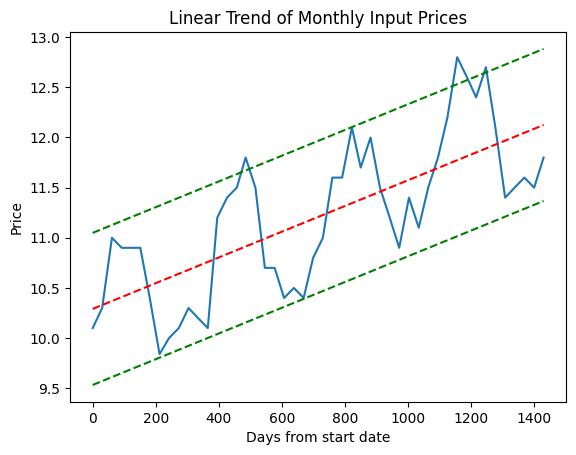

0.001282373598760221 10.29104112595228
[   0   30   61   92  120  151  181  212  242  273  304  334  365  395
  426  457  485  516  546  577  607  638  669  699  730  760  791  822
  850  881  911  942  972 1003 1034 1064 1095 1125 1156 1187 1216 1247
 1277 1308 1338 1369 1400 1430]


In [13]:
# couple diffrent reggessions 
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)
trend = time * slope + intercept
std = df['Prices'].std()
# Plot linear trend
plt.plot(time, prices)
plt.plot(time, trend,'r--')
plt.plot(time, trend - std, 'g--')
plt.plot(time, trend + std, 'g--')
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)


Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

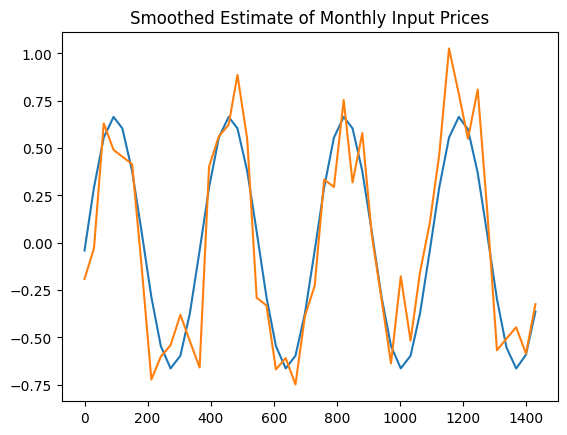

In [14]:
sin_prices = prices - (trend)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))
def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')

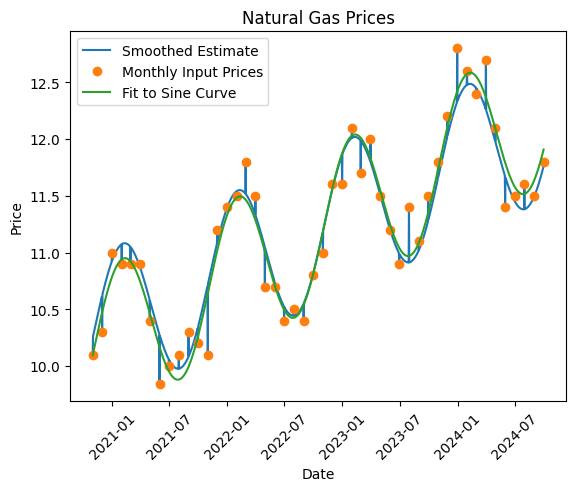

In [15]:
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation

smoothed_Esti = [interpolate(date) for date in continuous_dates]

plt.plot(continuous_dates, smoothed_Esti, label='Smoothed Estimate')

# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')

sin_fit = fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept
plt.plot(continuous_dates, sin_fit, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

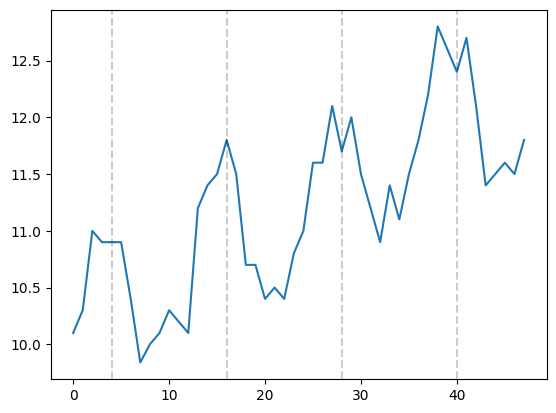

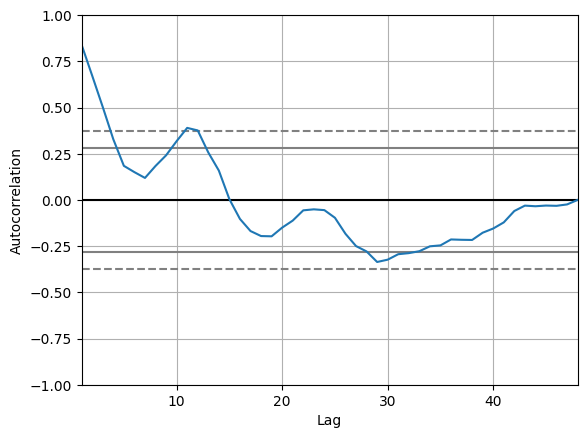

In [17]:
#since there is clearly a seasonal component use Sarima 
series1 = pd.Series(data = df['Prices'] )
series1.plot()
for jan in range(4,48,12):
    plt.axvline(x = jan, color='k', linestyle='--', alpha=0.2)
plt.show()

autocorrelation_plot(series1)
plt.show()

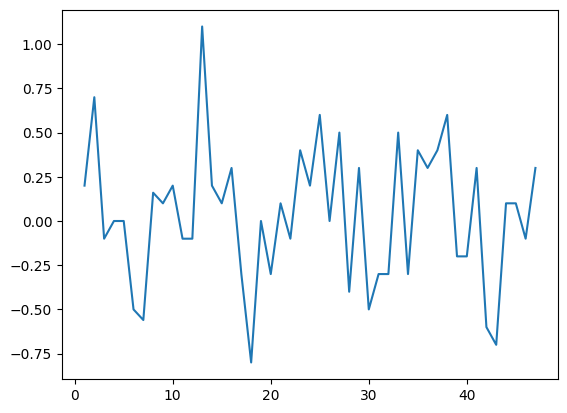

In [18]:
#check first differences 
first_diff = series1.diff()[1:]
plt.plot(first_diff)
plt.show()
#clearly 12 is the freq 

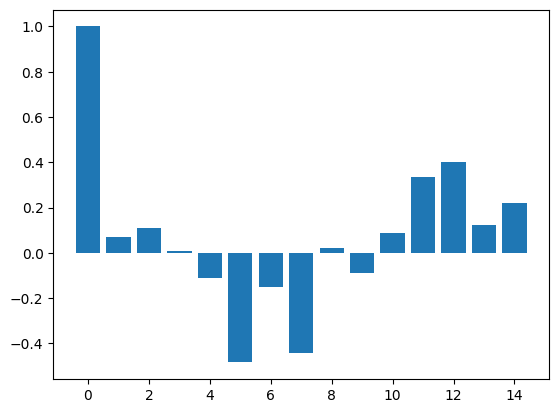

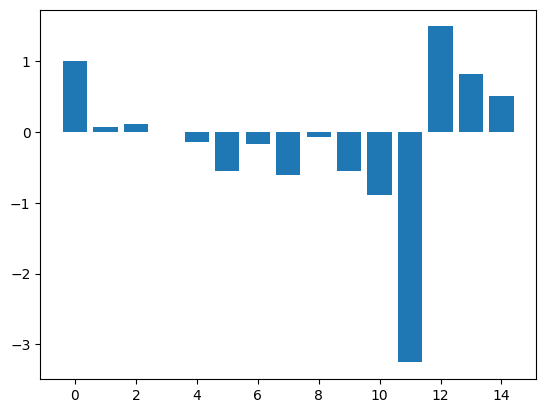

In [19]:
acf_vals = acf(first_diff)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.show()

pacf_vals = pacf(first_diff)

num_Plags = 15
plt.bar(range(num_Plags), pacf_vals[:num_Plags])
plt.show()

In [20]:
train_data = series1[:42]
test_data = series1[42:48]

order = (0,1,0)
S_order = (1,0,1,12)
model = SARIMAX(train_data,order = order,seasonal_order=S_order)
model_fit = model.fit()
print(model_fit.summary())
print("Price Prediction in 1-year"+ str(model_fit.predict(60)))

c:\Users\mabon\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                               Prices   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -15.080
Date:                              Mon, 28 Aug 2023   AIC                             36.160
Time:                                      20:45:16   BIC                             41.301
Sample:                                           0   HQIC                            38.032
                                               - 42                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9986      0.312      3.206      0.001       0.388       1.609
ma.S.L12      -0.95